In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# ostamand_midjourney_v0_path = kagglehub.dataset_download('ostamand/midjourney-v0')

# print('Data source import complete.')

# When running locally, you'll need to download the dataset manually and update the data_dir in the TrainingConfig class.
# You can download the dataset from: https://www.kaggle.com/datasets/ostamand/midjourney-v0
# Once downloaded, extract the contents and update the `data_dir` path in the TrainingConfig class below to point to the extracted folder.
print("Data source import complete. Please download the dataset manually when running locally.")

100%|██████████| 242M/242M [00:02<00:00, 114MB/s] 

Extracting files...


Data source import complete.


# Stable Diffusion 1.5: LoRA finetuning on Midjourney images

Fine-tuning on a dataset of images generated by Midjourney ([reference](https://huggingface.co/datasets/MohamedRashad/midjourney-detailed-prompts)). [Command R](https://huggingface.co/CohereForAI/c4ai-command-r-v01) is used to generate the short prompts used during training.

For the images only a subset of the original dataset are used. All of the square images (height=width) with 512px and more. All images are resized to 512px for training ([dataset resized](https://www.kaggle.com/datasets/ostamand/midjourney-v0)).

For simple comparison, two images are generated with and without the LoRA weights being applied.

The implementation of the LoRA finetuning is meant to be as simple as possible, keeping only what is needed to run on a single GPU having >12Gb VRAM.

In [3]:
%pip install diffusers
%pip install peft

In [1]:
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import login
from peft import LoraConfig
import torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from datasets import load_dataset
from functools import partial
from PIL import Image
# from kaggle_secrets import UserSecretsClient # Removed Kaggle-specific import
from torch.utils.data import Dataset
import pandas as pd
from pydantic import BaseModel
from diffusers.training_utils import compute_snr

In [ ]:
# login(token=UserSecretsClient().get_secret("HF_TOKEN")) # Removed Kaggle-specific code

# When running locally, you need to provide your Hugging Face token directly or set it as an environment variable.
# You can get your token from: https://huggingface.co/settings/tokens
# Option 1: Paste your token directly (less secure for sharing notebooks)
# login(token="YOUR_HF_TOKEN")

# Option 2: Set the HF_TOKEN environment variable before running the notebook
# import os
# os.environ["HF_TOKEN"] = "YOUR_HF_TOKEN"
# login()

# For now, we will skip the login as it's not strictly necessary for running the pipeline locally if the models are publicly available.
# If you need to access private models, uncomment one of the options above and provide your token.
print("Skipping Hugging Face login. Provide your HF_TOKEN if accessing private models.")

In [2]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

In [3]:
class MidjourneyDataset(Dataset):
    def __init__(self, data_dir: Path, tokenizer: CLIPTokenizer):
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "index.csv")
        self.tokenizer = tokenizer

        self.train_tranforms = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.data_dir / "images" / self.df.iloc[idx]["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.train_tranforms(image)

        input_ids = self.tokenizer(
            self.df.iloc[idx]["short_prompt"],
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}

In [4]:
def setup_models_for_training(model_name, rank: int=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze all weights
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # config LoRA
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # set trainaible weights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]

In [5]:
class TrainingConfig(BaseModel):
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 4
    accumulation_steps: int = 2
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    data_dir: str = "/content/drive/MyDrive/LoRA_Dataset/input"
    snr_gamma: float = -1
    seed: int = -1

In [6]:
def train(
    tokenizer: CLIPTokenizer,
    text_encoder: CLIPTextModel,
    vae: AutoencoderKL,
    scheduler: DDPMScheduler,
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # data set
    train_dataset = MidjourneyDataset(Path(config.data_dir), tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # optimizer
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

    # progress bar setup
    global_step = 0
    progress_bar = tqdm(
        range(config.train_steps),
        desc="Steps"
    )

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    # should converge faster with snr_gamma, however works well with unweighted mse
                    # https://arxiv.org/abs/2303.09556
                    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step+=1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())

            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break

    return {
        "losses": losses
    }

In [7]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 1000
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/tmp/ipython-input-935945457.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

configs: train_steps=1000 lr=1e-05 batch_size=4 accumulation_steps=2 rank=62 max_grad_norm=1.0 pretrained_name='runwayml/stable-diffusion-v1-5' data_dir='/content/input' snr_gamma=5.0 seed=42
epochs: 11
steps per epoch: 94
total steps: 1000
accumulation steps: 2
total batch size: 8
lr: 8e-05


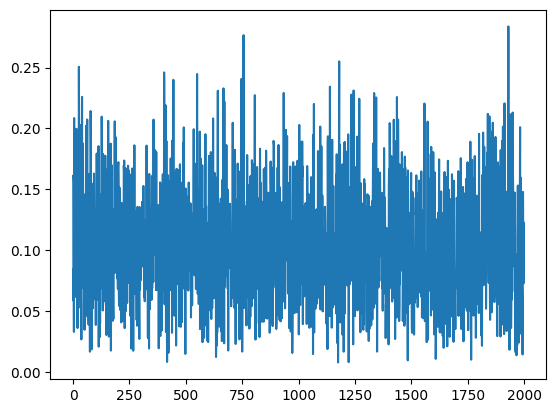

In [8]:
plt.plot(outputs["losses"])
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Save LoRA weights

In [9]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [10]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

In [11]:
!ls -l -h ./out/pytorch_lora_weights.safetensors

-rw-r--r-- 1 root root 48M Oct 29 07:26 ./out/pytorch_lora_weights.safetensors


Compare inference with and without LoRA weights applied.

We will generate two images per model. One from a taken from the training data (a robot with an unbrella) and one new.

In [12]:
df = pd.read_csv(Path(config.data_dir) / "index.csv")

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompt_training = [df.iloc[0]["short_prompt"]]
prompt_new = "a dark forest, detailed, 8k"
num_inference_steps=35
seed = 3

In [14]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

In [15]:
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

Display image take from training data for reference

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

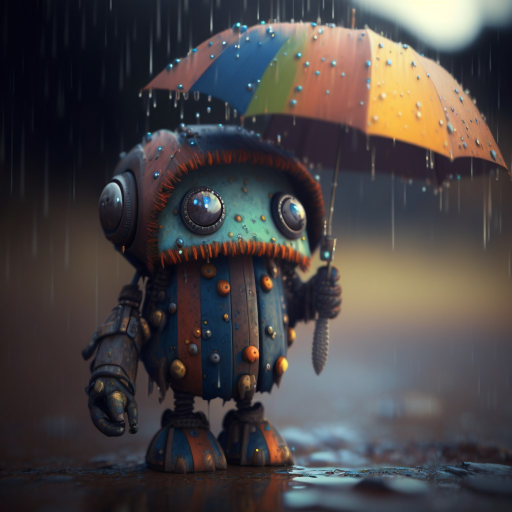

In [16]:
Image.open(Path(config.data_dir) / "images" / df.iloc[0]["image"])

Generate images from pretrained model. First the training image, then the new prompt

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

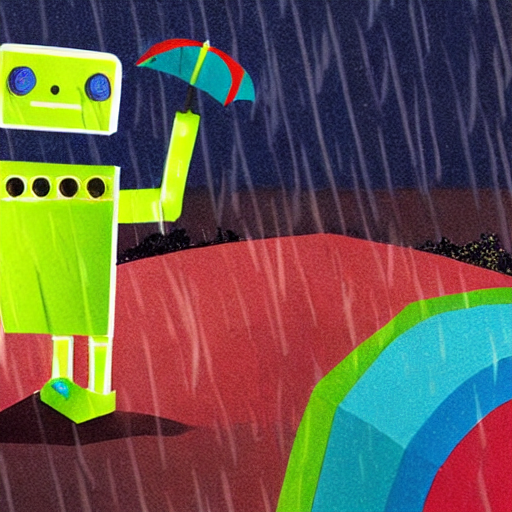

In [17]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

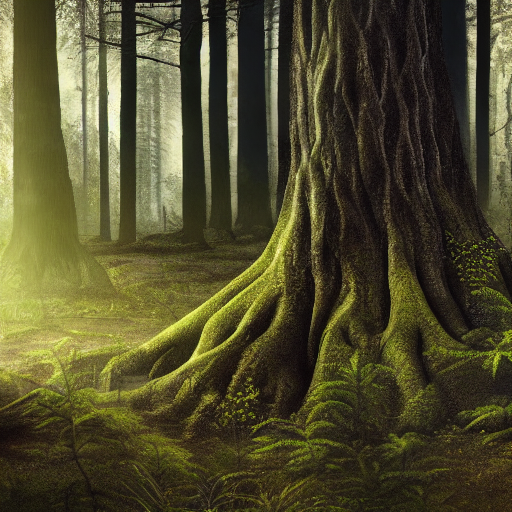

In [18]:
generate(pipe, prompt_new, seed)

Apply the LoRA weights and run the same two prompts.

In [19]:
pipe.load_lora_weights("./out/pytorch_lora_weights.safetensors")

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

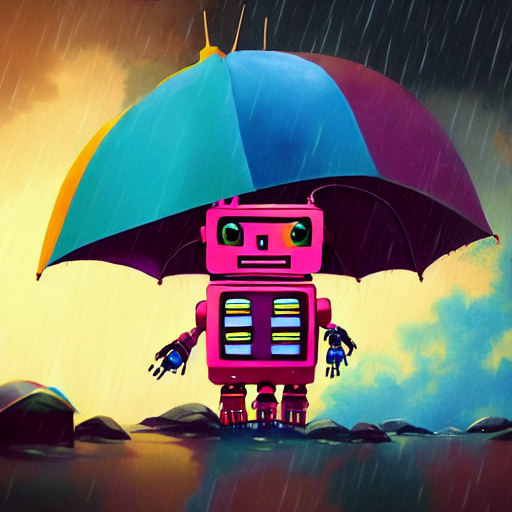

In [20]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'AutoencoderKL' object attribute is deprecated. Please access '__iter__' over 'AutoencoderKL's config object instead, e.g. 'unet.config.__iter__'.
  if not hasattr(obj, "__iter__"):
/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `__iter__` directly via 'DDPMScheduler' object attribute is deprecated. Please access '__iter__' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.__iter__'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.12/dist-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_safe_repr.py:128: FutureWarning: Accessing config attribute `__iter__` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access '__iter__' over 'UN

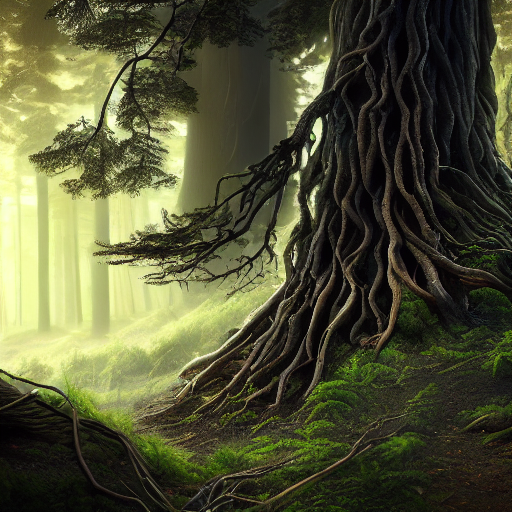

In [23]:
generate(pipe, prompt_new, seed)

We get a very different style after applying the LoRA trained weights.